# Materialize eBay data

1. Download and unzip the file `anon_bo_lists.csv` and put it in a subfolder, `./Raw/`.
2. Run this notebook.
3. Clean up unused large files if needed.

**Output:** `ebay_smaller.parquet` (a smaller, more manageable dataset)

***Warning:*** The file is extremely large to read in and work with. 

In [ ]:
import pandas as pd 
import numpy as np 

In [ ]:
dat = pd.read_csv('Raw/anon_bo_lists.csv')

# Drop some rows

In [ ]:
dat = dat[dat.item_price.notnull()].copy()

In [ ]:
cats = {1: 'Collectibles',	99: 'Everything Else',	220: 'Toys & Hobbies',	237: 'Dolls & Bears',
        260:'Stamps',	267: 'Books',	281: 'Jewelry & Watches',	293: 'Computers & Electronics',
        293: 'Consumer Electronics',	316: 'Specialty Services',	550: 'Art',
        619: 'Musical Instruments & Gear',	625: 'Cameras & Photo',	870: 'Pottery & Glass',
        888: 'Sporting Goods',	1249: 'Video Games & Consoles',	1281: 'Pet Supplies',
        1305: 'Tickets & Experiences',	2984: 'Baby',	3252: 'Travel',	6000: 'eBay Motors',
        10542: 'Real Estate',	11116: 'Coins',	11116: 'Coins & Paper Money',	11232: 'DVDs & Movies',
        11233: 'Music',	11450: 'Clothing Shoes & Accessories',	11700: 'Home',	11700: 'Home & Garden',
        12576: 'Business & Industrial',	14339: 'Crafts',	15032: 'Cell Phones & Accessories',	20081:
        'Antiques',	26395: 'Health & Beauty',	45100: 'Entertainment Memorabilia',
        58058: 'Computers/Tablets & Networking',	64482: 'Sports Mem Cards & Fan Shop',
        172008: 'Gift Cards & Coupons'}

Drop the two largest and two smallest categories. 

In [ ]:
I = dat.metacat.isin(['Clothing Shoes & Accessories', 'Everything Else', 'Collectibles', 'Real Estate', 'Specialty Services'])
dat.loc[I, 'metacat'].value_counts()

# replace dat so that we clean up and reduce the memory footprint 
dat = dat.loc[I == False, :].copy()

In [23]:
dat['metacat'] = dat.meta_categ_id.map(cats).astype('category')

No need to be storing the original index. 

In [ ]:
dat.set_index('anon_item_id', inplace=True)

In [25]:
cols_del = ['count2', 'ref_price2', 'count3', 'ref_price3', 'count4', 'ref_price4']
for c in cols_del: 
    del dat[c]

In [27]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13230182 entries, 14203427 to 15499758
Data columns (total 32 columns):
 #   Column              Dtype   
---  ------              -----   
 0   anon_title_code     int64   
 1   anon_product_id     int64   
 2   anon_leaf_categ_id  int64   
 3   anon_slr_id         int64   
 4   anon_buyer_id       float64 
 5   auct_start_dt       object  
 6   fdbk_score_start    float64 
 7   fdbk_pstv_start     float64 
 8   auct_end_dt         object  
 9   start_price_usd     float64 
 10  photo_count         int64   
 11  to_lst_cnt          int64   
 12  bo_lst_cnt          int64   
 13  count1              float64 
 14  ref_price1          float64 
 15  view_item_count     int64   
 16  wtchr_count         int64   
 17  meta_categ_id       int64   
 18  item_price          float64 
 19  bo_ck_yn            float64 
 20  ship_time_slowest   float64 
 21  ship_time_fastest   float64 
 22  ship_time_chosen    float64 
 23  decline_price       flo

# Data conversions

In [28]:
cats_condition = {1000.0: 'New',1500.0: 'New other',1750.0: 'New with defects',2000.0: 'Manufacturer refurbished',2500.0: 'Seller refurbished',2750.0: 'Like New',3000.0: 'Used',4000.0: 'Very Good',5000.0: 'Good',6000.0: 'Acceptable',7000.0: 'For parts / not working'}

In [ ]:
dat['item_condition'] = dat.item_cndtn_id.map(cats_condition).astype('category')
del dat['item_cndtn_id']

In [30]:
dat.auct_end_dt = pd.to_datetime(dat.auct_end_dt)
dat.auct_start_dt = pd.to_datetime(dat.auct_start_dt)

In [31]:
cols_bool = ['accept_price', 'decline_price', 'slr_us', 'buyer_us', 'bo_ck_yn', 'bin_rev', 'store', 'bin_rev']
for c in cols_bool: 
    dat[c] = dat[c].astype('bool')

In [33]:
cols_del = ['ship_time_fastest', 'ship_time_slowest', 'ship_time_chosen']
for c in cols_del: 
    del dat[c]

# Save

In [43]:
dat.to_parquet('ebay_smaller.parquet')

# Simple descriptives

We want to compare prices across listings. To do this, the price is normalized to make it more comparable. There are two obvious candidates for normalizing the price: 

1. The starting price: bidders tend to not pay more than the listing price, 
2. A "reference price" available in the raw dataset: this is an average within a narrow product type category. 

In [44]:
dat['price_rel2start'] = dat.item_price / dat.start_price_usd

In [55]:
dat['price_rel2ref'] = dat.item_price / dat.ref_price1

Subsample dataset to a smaller set of categories

In [67]:
groups = ['Art', 'Cell Phones & Accessories', 'Musical Instruments & Gear', 'Antiques']
I = (dat.metacat.isin(groups)) & (dat.store == False)
print(f'original {dat.shape}')
print(f'Reduced {I.sum()} ({I.mean()})')
dat2 = dat[I].copy()

In [70]:
import matplotlib.pyplot as plt

In [71]:
dat2.metacat = dat2.metacat.cat.remove_unused_categories() # pandas still adds plots for empty categories... :(

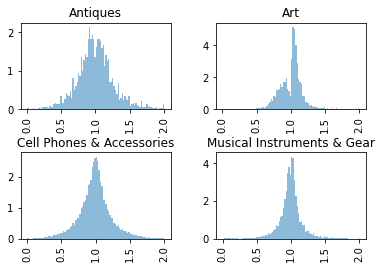

In [72]:
ax=dat2[(dat2.price_rel2ref <= 2) & (dat2.price_rel2ref != 1.0)].hist('price_rel2ref', by='metacat', density=True, bins=100, alpha=0.5); 

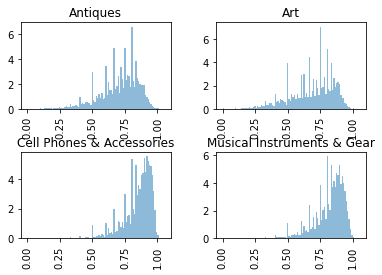

In [73]:
ax=dat2[(dat2.price_rel2start <= 1.05) & (dat2.price_rel2start != 1.0)].hist('price_rel2start', by='metacat', density=True, bins=100, alpha=0.5); 